In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD


In [2]:
kline_data = pd.read_csv('./train_data.csv')

In [3]:
kline_data['kline_open_time'] = pd.to_datetime(kline_data['kline_open_time'])

In [4]:
set_shape = 2700 
train_set = kline_data.iloc[:set_shape,4:5].values
test_set = kline_data.iloc[set_shape:,4:5].values

In [5]:
# Нормализуем данные 
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)



In [6]:
# Изменим структуру таким оброзом, чтобы получить 60 временных шагов и один выход 
window = 60 
X_train =[]
y_train =[]
for i in tqdm(range(window, set_shape)):
    X_train.append(train_set_scaled[i-window:i, 0])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)



  0%|          | 0/2640 [00:00<?, ?it/s]

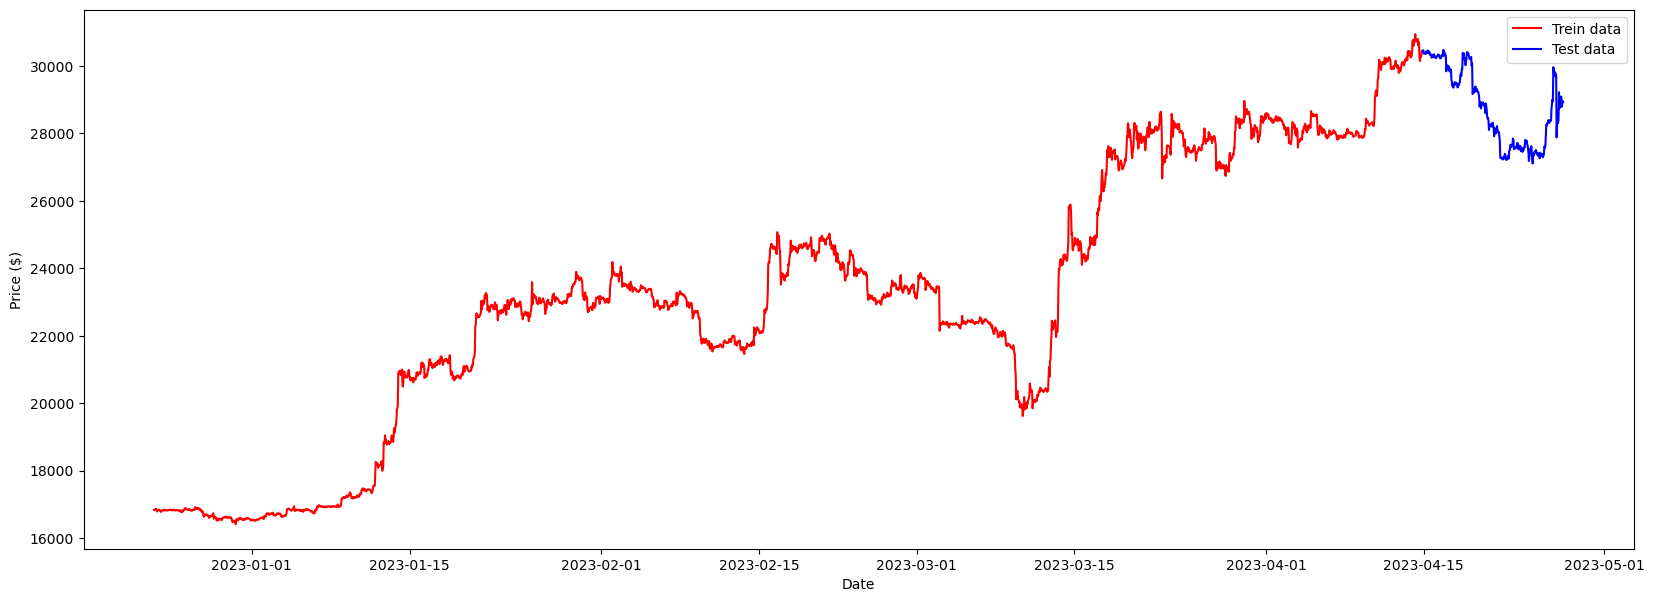

In [7]:
plt.figure(figsize=(20,7))
plt.plot(kline_data['kline_open_time'][:set_shape], kline_data.iloc[:set_shape,4:5].values, color = 'red', label = 'Trein data')
plt.plot(kline_data['kline_open_time'][set_shape:], kline_data.iloc[set_shape:,4:5].values , color = 'blue', label = 'Test data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [8]:

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 1000, batch_size = 32)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/1000


2023-04-27 15:07:30.604296: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


83/83 [==============================] - 6s 40ms/step - loss: 0.0207
Epoch 2/1000
83/83 [==============================] - 3s 37ms/step - loss: 0.0016
Epoch 3/1000
83/83 [==============================] - 3s 37ms/step - loss: 0.0013
Epoch 4/1000
83/83 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 5/1000
83/83 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 6/1000
83/83 [==============================] - 3s 38ms/step - loss: 8.4168e-04
Epoch 7/1000
83/83 [==============================] - 3s 39ms/step - loss: 7.4042e-04
Epoch 8/1000
83/83 [==============================] - 3s 39ms/step - loss: 7.4647e-04
Epoch 9/1000
83/83 [==============================] - 3s 37ms/step - loss: 7.5192e-04
Epoch 10/1000
83/83 [==============================] - 3s 38ms/step - loss: 8.3260e-04
Epoch 11/1000
83/83 [==============================] - 3s 39ms/step - loss: 8.4612e-04
Epoch 12/1000
83/83 [==============================] - 3s 37ms/step - loss: 7.5008e-0

In [9]:

dataset_total = np.vstack((train_set, test_set))
inputs = dataset_total[dataset_total.shape[0] - test_set.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = dataset_total.shape[0] - set_shape + window
X_test = []
for i in range(window, num_2):
  X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
  X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [10]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)



10/10 [==============================] - 1s 19ms/step


In [11]:
diff = predict - test_set

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 358972.5384150337
MAE: 574.6139083333333
RMSE: 599.143170214794


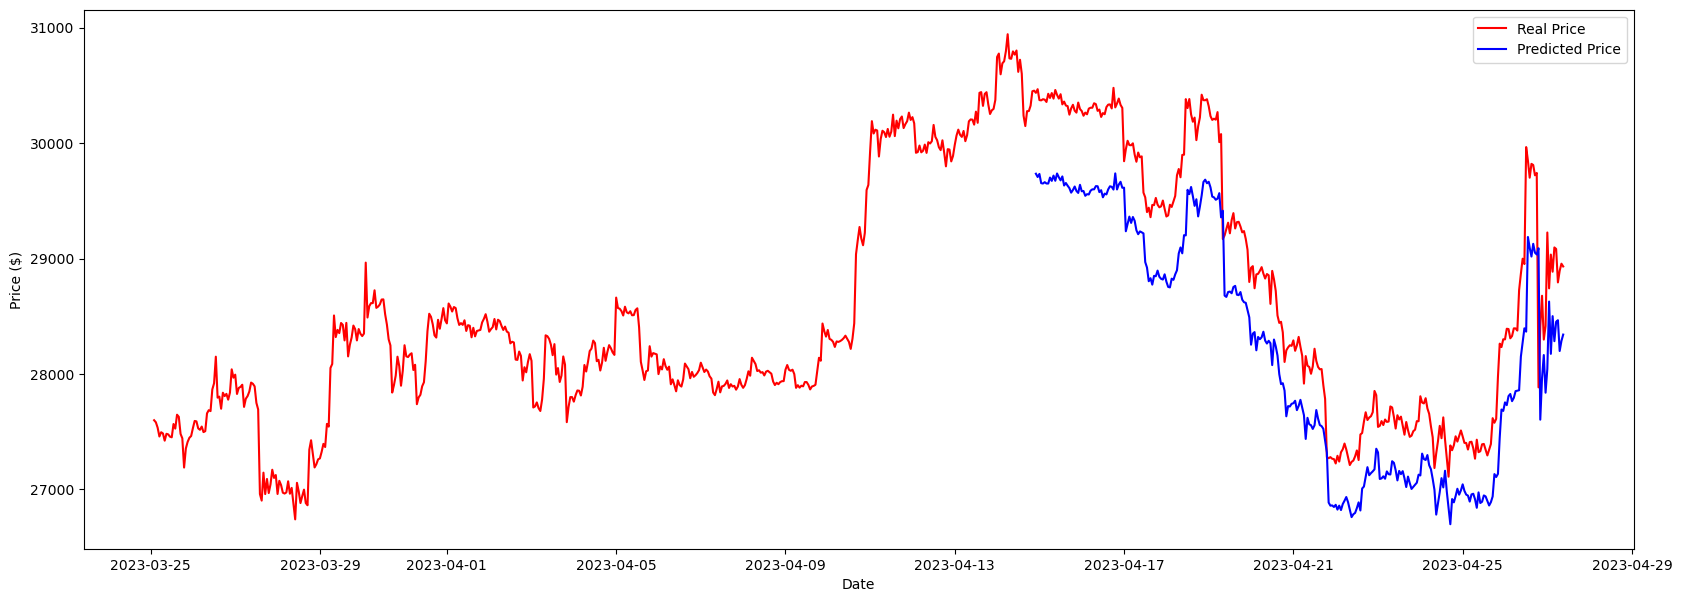

In [12]:
plt.figure(figsize=(20,7))
plt.plot(kline_data['kline_open_time'][set_shape-500:], kline_data.iloc[set_shape-500:,4:5].values, color = 'red', label = 'Real Price')
plt.plot(kline_data['kline_open_time'][-predict.shape[0]:], predict, color = 'blue', label = 'Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [13]:
# Предсказания на 20 часов вперед
pred_ = predict[-1].copy()
all_prediction = []
kline_data_copy = kline_data.iloc[:,4:5][1:].values
coint_of_pred_days = 10
for i in range(coint_of_pred_days):
    kline_data_ = np.vstack((kline_data_copy,pred_))
    train_set_ = kline_data_[:set_shape]
    test_set_ = kline_data_[set_shape:]
    inputs_ = kline_data_[kline_data_.shape[0] - test_set_.shape[0] - window :].reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k,0], (window,1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    all_prediction.append(pred_[-1][0])
    kline_data_copy = kline_data_[i:]





10/10 [==============================] - 0s 12ms/step


In [14]:
prediction_full_new = np.vstack((predict, np.array(all_prediction).reshape(-1,1)))

In [15]:
kline_data_date = kline_data['kline_open_time']
for i in range(coint_of_pred_days):
    df_add_date = pd.to_datetime(kline_data_date.iloc[-1]) + pd.DateOffset(hours=1)
    df_add_date = pd.Series(df_add_date)
    kline_data_date = pd.concat([kline_data_date,df_add_date])
kline_data_date.reset_index(inplace=True,drop=True)  


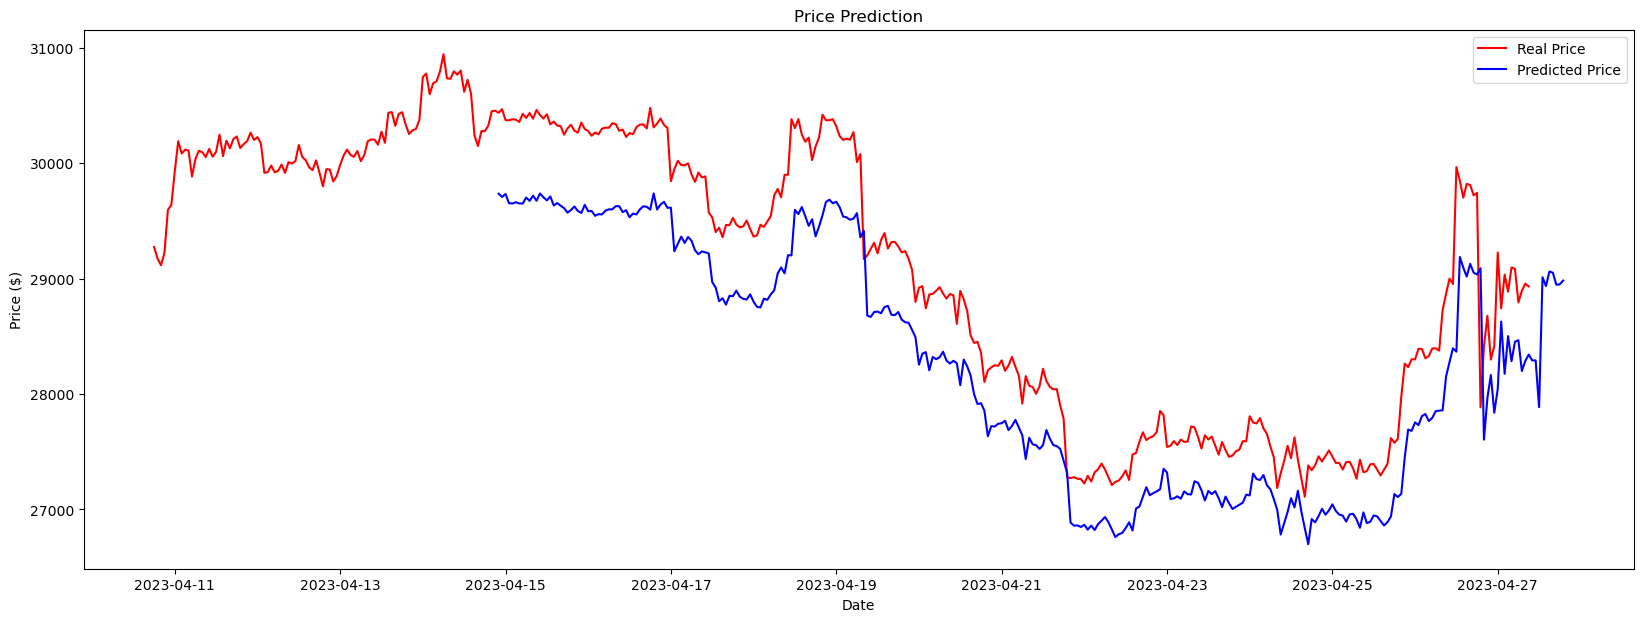

In [16]:
plt.figure(figsize=(20,7))
plt.plot(kline_data['kline_open_time'].values[set_shape-100:], kline_data['close_price'][set_shape-100:].values, color = 'red', label = 'Real Price')
plt.plot(kline_data_date[-prediction_full_new.shape[0]:], prediction_full_new, color = 'blue', label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()